## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

In [2]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [3]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [4]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

,Satz,Tokens,Klassierung,Bemerkungen,label
0,<noinclude> </noinclude> Beispiele Für...,"['noinclude', '', 'noinclude', 'beispiele', 'f...",LOW_QUALITY,NaN,LOW_QUALITY
1,Originalien Chirurg 2010 · 81:1005–1012 DOI 10...,"['originalien', 'chirurg', '2010', '', '811005...",REFERENCE,NaN,REFERENCE
2,Wollte man sich durch entsprechende Lektüre nu...,"['wollte', 'man', 'sich', 'durch', 'entspreche...",SENTENCE,NaN,SENTENCE
3,"Diese Kategorie enthält Kraftwerk e, die durc...","['diese', 'kategorie', 'enthält', 'kraftwerk',...",SENTENCE,NaN,SENTENCE
4,Pluggable Authentication Modules ( PAM ) ist ...,"['pluggable', 'authentication', 'modules', 'pa...",SENTENCE,NaN,SENTENCE


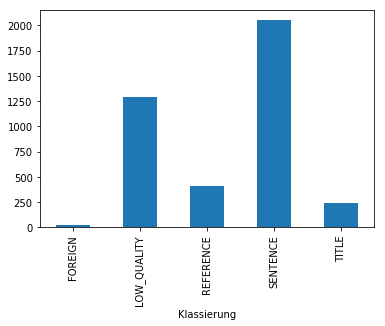

In [5]:
# set targets

data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()

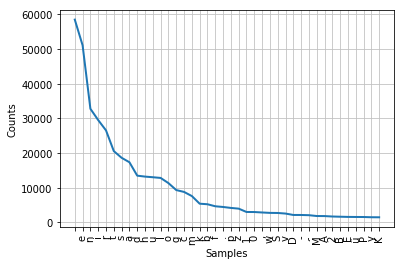

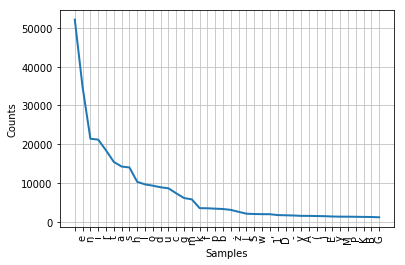

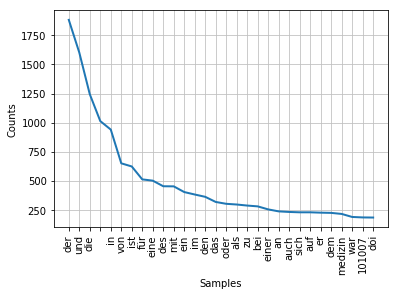

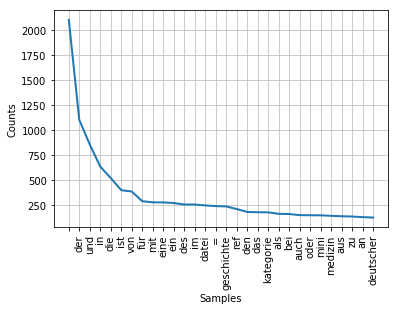

In [6]:
# character frequency analysis

high_quality = data.loc[data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]]

fdc = nltk.FreqDist()
tokens_h = []
for s in high_quality['Satz']:
    tokens_h.extend(tokenizer.tokenize(s))
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

tokens_l = []
fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    tokens_l.extend(tokenizer.tokenize(s))
    fdc2.update(s)
    fdc.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)

# word frequencies
fd = nltk.FreqDist(tokens_h)
fd.plot(30,cumulative=False) 
fd = nltk.FreqDist(tokens_l)
fd.plot(30,cumulative=False) 

In [7]:
# set input data

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='utf8', ngram_range=(2, 2), stop_words='english')
tfidf = tfidf.fit(data.Satz)

fd = nltk.FreqDist(tokens_h + tokens_l)

voc_chars = list(fdc.keys())[:200]
voc_words = list(fd.keys())[:500]

def convert_sentence_to_input(s):
    tokens = tokenizer.tokenize(s)
    fd_words = nltk.FreqDist(tokens)
    fd_chars = nltk.FreqDist(s)
    
    words = [fd_words.freq(w) for w in voc_words]
    chars = [fd_chars.freq(c) for c in voc_chars]
    
    words_in_vocab = sum(1 for i in words if i > 0.0)
    long_tail = float(words_in_vocab) /  len(tokens)
    
    tfidf_features = list(tfidf.transform([s]).toarray()[0])
    
    return np.array(words + chars + [long_tail/10.0], dtype=np.float32)

data['input'] = pd.Series([[convert_sentence_to_input(s)] for s in data['Satz']], index=data.index)
data.head()

,Satz,Tokens,Klassierung,Bemerkungen,label,input
0,<noinclude> </noinclude> Beispiele Für...,"['noinclude', '', 'noinclude', 'beispiele', 'f...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0909091, 0.0, 0.0, 0.0, 0.0..."
1,Originalien Chirurg 2010 · 81:1005–1012 DOI 10...,"['originalien', 'chirurg', '2010', '', '811005...",REFERENCE,NaN,REFERENCE,"[[0.010989, 0.010989, 0.032967, 0.0879121, 0.0..."
2,Wollte man sich durch entsprechende Lektüre nu...,"['wollte', 'man', 'sich', 'durch', 'entspreche...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"Diese Kategorie enthält Kraftwerk e, die durc...","['diese', 'kategorie', 'enthält', 'kraftwerk',...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Pluggable Authentication Modules ( PAM ) ist ...,"['pluggable', 'authentication', 'modules', 'pa...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0454545, 0.0, 0.0, 0.0, 0.0..."


In [11]:
# fit a model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=16, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='linear', gamma=2),
    # SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf', gamma=2),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16, 8), random_state=1)
]

X_train, X_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), data['label'], random_state = 2)

print(X_train.shape)

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [model.fit(X_train, y_train) for model in models]


(3003, 701)


In [27]:
# Keras MLP
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

batch_size = 128
num_classes = len(classes)
epochs = 1000


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# early stopping criterion
early_stopping = EarlyStopping(monitor='val_acc', patience=20)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, dummy_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, dummy_y_test),
                    callbacks=[early_stopping])
score = model.evaluate(X_test, dummy_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               89856     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 645       
Total params: 107,013
Trainable params: 107,013
Non-trainable params: 0
_________________________________________________________________
Train on 3003 samples, validate on 1001 samples
Epoch 1/1000
3003/3003 [==============================] - 0s - loss: 1.3208 - acc: 0.498

RandomForestClassifier: 0.601398601399
RandomForestClassifier: 0.695304695305
RandomForestClassifier: 0.761238761239
LinearSVC: 0.745254745255
LogisticRegression: 0.662337662338
SVC: 0.668331668332
SVC: 0.729270729271
MLPClassifier: 0.769230769231
MLPClassifier: 0.775224775225
MLPClassifier: 0.776223776224
MLPClassifier: 0.765234765235
MLPClassifier: 0.753246753247


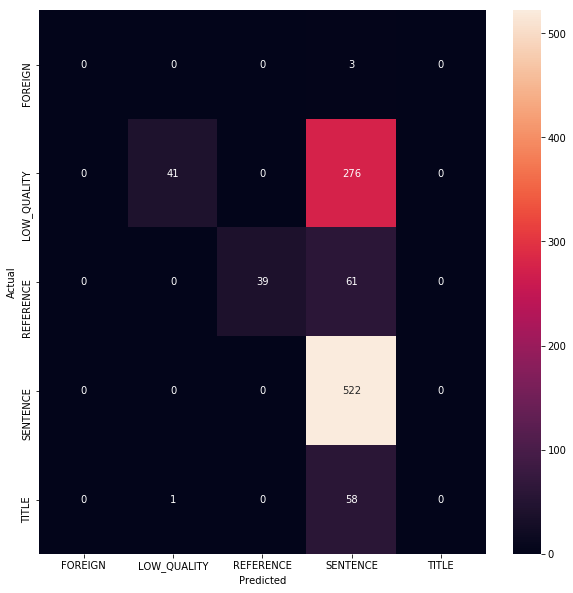

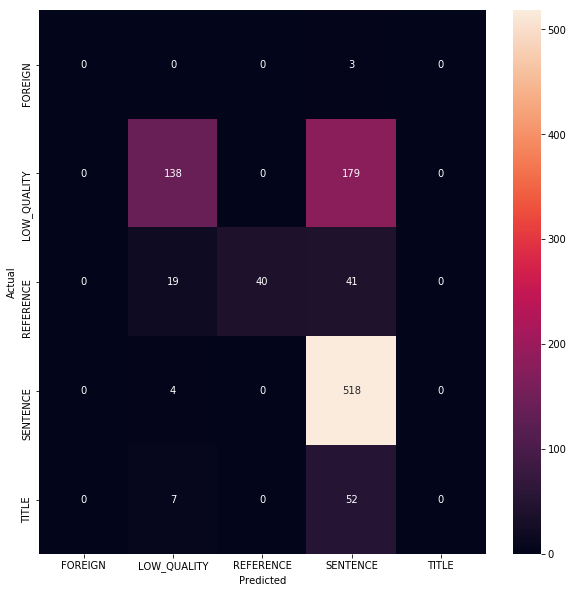

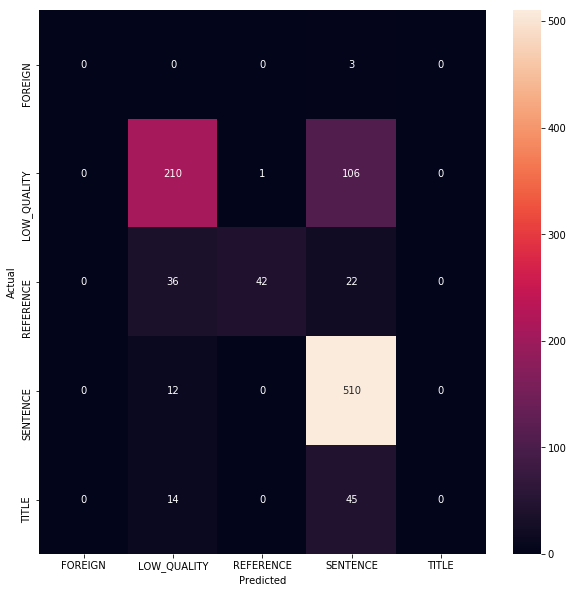

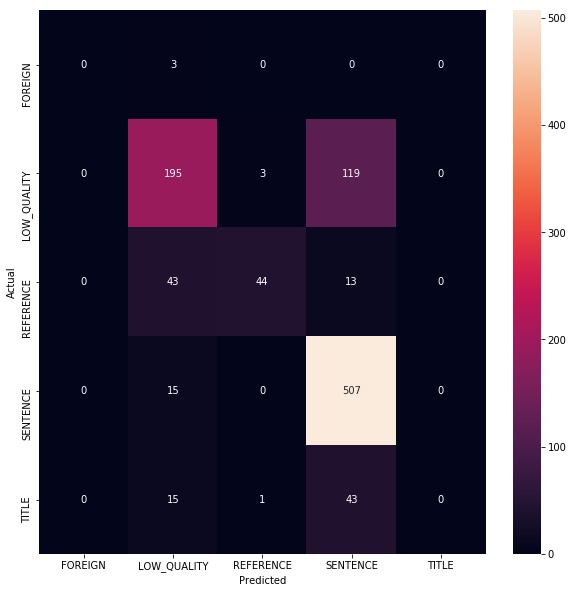

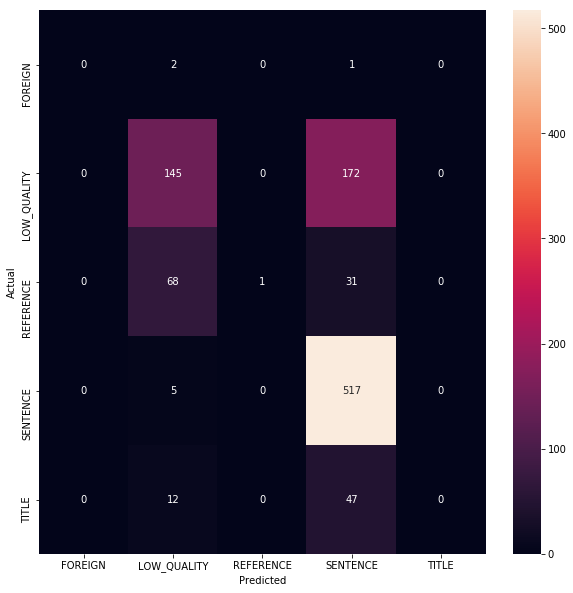

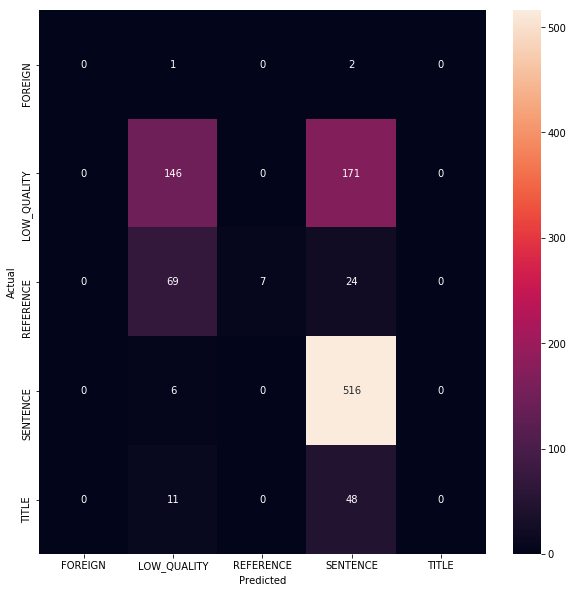

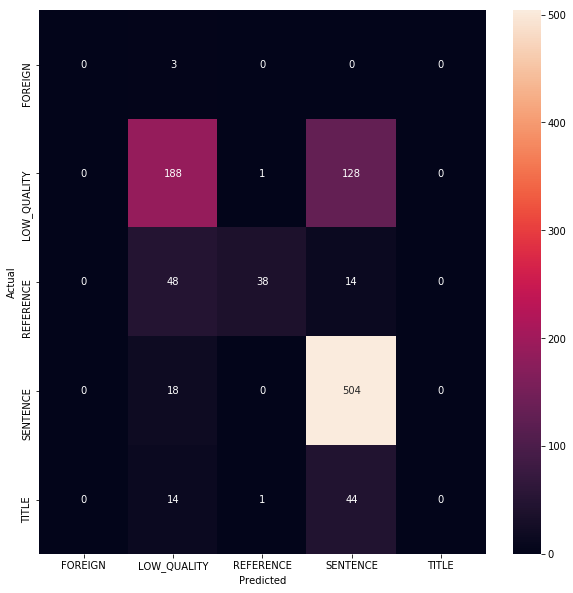

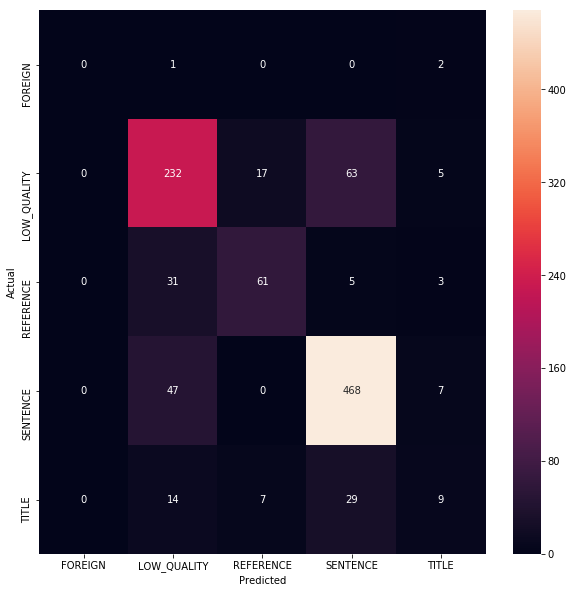

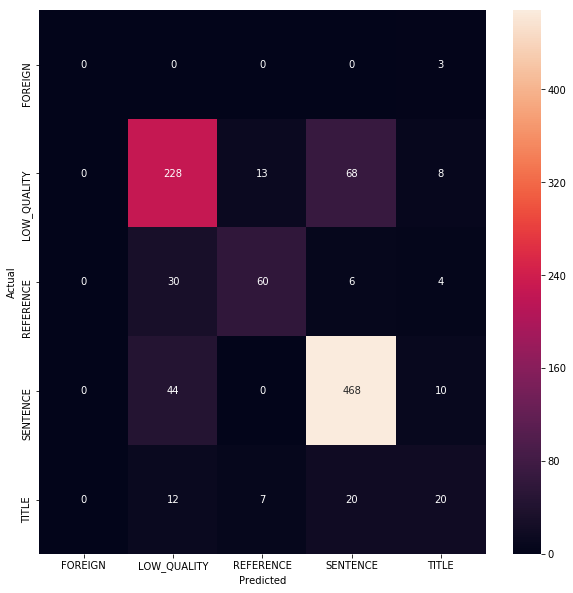

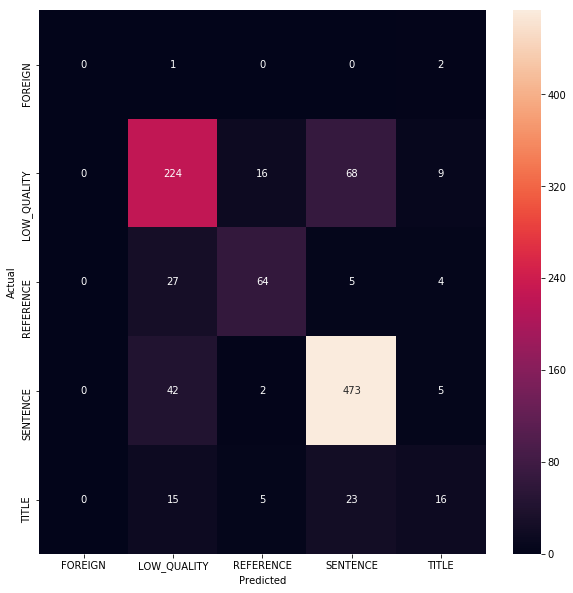

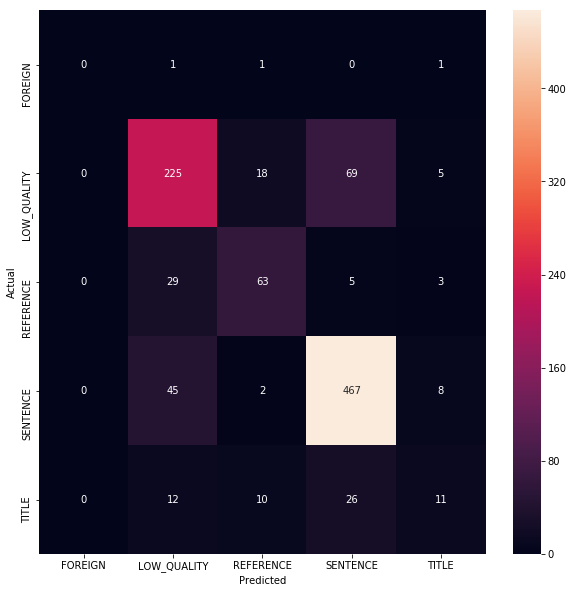

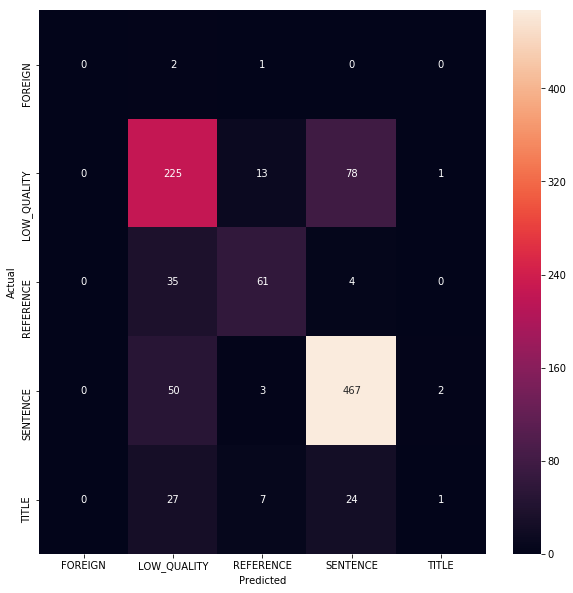

In [12]:
# model evaluation

for model in models:
    y_pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print(model.__class__.__name__ + ": " + str(accuracy_score(y_test, y_pred)))

    conf_mat = confusion_matrix(y_test, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()